<a href="https://colab.research.google.com/github/OliviaJulfasinta/intrusion-detection-system/blob/main/Perbandingan_Algoritma_Deep_Learning_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Unduh dataset NSL-KDD
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt

--2025-03-26 17:34:20--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘KDDTrain+.txt’

KDDTrain+.txt       100%[===================>]  18.22M  --.-KB/s    in 0.1s    

2025-03-26 17:34:20 (166 MB/s) - ‘KDDTrain+.txt’ saved [19109424/19109424]

--2025-03-26 17:34:20--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3441513 (3.3M) [text/plain]
Sa

In [2]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Input, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import time

# Mengatur tampilan grafik
plt.style.use('ggplot')

In [3]:
# Fungsi untuk memuat dataset
def load_dataset(train_path, test_path):
    # Nama kolom dataset NSL-KDD
    columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
              'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
              'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
              'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
              'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
              'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
              'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
              'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
              'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class', 'difficulty']

    # Memuat dataset
    train_data = pd.read_csv(train_path, header=None, names=columns)
    test_data = pd.read_csv(test_path, header=None, names=columns)

    # Menghapus kolom difficulty yang tidak relevan
    train_data.drop('difficulty', axis=1, inplace=True)
    test_data.drop('difficulty', axis=1, inplace=True)

    return train_data, test_data

# Fungsi untuk preprocessing data
def preprocess_data(train_data, test_data):
    # Mengubah label menjadi biner (normal = 0, attack = 1)
    train_data['binary_class'] = train_data['class'].apply(lambda x: 0 if x == 'normal' else 1)
    test_data['binary_class'] = test_data['class'].apply(lambda x: 0 if x == 'normal' else 1)

    # Pisahkan fitur dan label
    X_train = train_data.drop(['class', 'binary_class'], axis=1)
    y_train = train_data['binary_class']
    X_test = test_data.drop(['class', 'binary_class'], axis=1)
    y_test = test_data['binary_class']

    # Identifikasi fitur kategorikal dan numerik
    categorical_cols = ['protocol_type', 'service', 'flag']
    numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

    # One-hot encoding untuk fitur kategorikal
    encoder = OneHotEncoder(sparse_output=False)
    X_train_cat = encoder.fit_transform(X_train[categorical_cols])
    X_test_cat = encoder.transform(X_test[categorical_cols])

    # Normalisasi fitur numerik
    scaler = MinMaxScaler()
    X_train_num = scaler.fit_transform(X_train[numeric_cols])
    X_test_num = scaler.transform(X_test[numeric_cols])

    # Gabungkan fitur kategorikal dan numerik
    X_train_processed = np.hstack((X_train_num, X_train_cat))
    X_test_processed = np.hstack((X_test_num, X_test_cat))

    # Membagi data train menjadi train dan validation
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train_processed, y_train, test_size=0.15, random_state=42
    )

    return X_train_final, X_val, X_test_processed, y_train_final, y_val, y_test, X_train_processed.shape[1]

In [4]:
# 1. Model DNN (Deep Neural Network)
def build_dnn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 2. Model LSTM (Long Short-Term Memory)
def build_lstm_model(input_dim):
    # Reshape menjadi dimensi yang sesuai untuk LSTM (samples, timesteps, features)
    inp = Input(shape=(1, input_dim))

    x = LSTM(128, return_sequences=True)(inp)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 3. Model CNN (Convolutional Neural Network)
def build_cnn_model(input_dim):
    # Reshape menjadi dimensi yang sesuai untuk CNN 1D
    inp = Input(shape=(input_dim, 1))

    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 4. Model Hybrid (CNN-LSTM)
def build_hybrid_model(input_dim):
    inp = Input(shape=(input_dim, 1))

    # CNN layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # LSTM layers
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 5. Model Deep Dense Network
def build_deep_dense_model(input_dim):
    inp = Input(shape=(input_dim,))

    # First branch
    x1 = Dense(128, activation='relu')(inp)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(64, activation='relu')(x1)

    # Second branch
    x2 = Dense(64, activation='relu')(inp)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    x2 = Dense(32, activation='relu')(x2)

    # Merge branches
    x = concatenate([x1, x2])
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [5]:
# Fungsi untuk melatih model
def train_model(model, X_train, y_train, X_val, y_val, model_type, epochs=10, batch_size=64):
    # Reshape data jika diperlukan untuk model tertentu
    if model_type == 'lstm':
        X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    elif model_type == 'cnn' or model_type == 'hybrid':
        X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    else:  # 'dnn' or 'deep_dense'
        X_train_reshaped = X_train
        X_val_reshaped = X_val

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    start_time = time.time()
    history = model.fit(
        X_train_reshaped, y_train,
        validation_data=(X_val_reshaped, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    training_time = time.time() - start_time

    return model, history, training_time

# Fungsi untuk evaluasi model
def evaluate_model(model, X_test, y_test, model_type):
    # Reshape data jika diperlukan untuk model tertentu
    if model_type == 'lstm':
        X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    elif model_type == 'cnn' or model_type == 'hybrid':
        X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    else:  # 'dnn' or 'deep_dense'
        X_test_reshaped = X_test

    # Prediksi probabilitas
    start_time = time.time()
    y_pred_prob = model.predict(X_test_reshaped)
    inference_time = time.time() - start_time

    # Konversi probabilitas ke label biner
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'inference_time': inference_time
    }

In [7]:
# Fungsi untuk membandingkan semua model
def compare_models(models_results):
    models = list(models_results.keys())

    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'training_time', 'inference_time']
    comparison = pd.DataFrame(index=models, columns=metrics)

    for model_name in models:
        for metric in metrics:
            if metric in models_results[model_name]:
                comparison.loc[model_name, metric] = models_results[model_name][metric]

    return comparison

# Fungsi untuk visualisasi perbandingan model
def visualize_comparison(comparison_df):
    # Plot metrik performa
    plt.figure(figsize=(14, 8))
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    comparison_df[metrics].plot(kind='bar')
    plt.title('Perbandingan Metrik Performa Model')
    plt.ylabel('Nilai')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('model_performance_comparison.png')
    plt.show()

    # Plot waktu pelatihan dan inferensi
    plt.figure(figsize=(14, 6))
    time_metrics = ['training_time', 'inference_time']
    comparison_df[time_metrics].plot(kind='bar')
    plt.title('Perbandingan Waktu Pelatihan dan Inferensi Model')
    plt.ylabel('Waktu (detik)')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('model_time_comparison.png')
    plt.show()

    return comparison_df

In [8]:
# Fungsi utama untuk menjalankan eksperimen
def run_experiment():
    print("Memuat dataset NSL-KDD...")
    train_data, test_data = load_dataset("KDDTrain+.txt", "KDDTest+.txt")

    print("Melakukan preprocessing data...")
    X_train, X_val, X_test, y_train, y_val, y_test, input_dim = preprocess_data(train_data, test_data)

    print(f"Dimensi data: {input_dim}")
    print(f"Jumlah data training: {X_train.shape[0]}")
    print(f"Jumlah data validasi: {X_val.shape[0]}")
    print(f"Jumlah data testing: {X_test.shape[0]}")

    # Dictionary untuk menyimpan semua hasil
    all_results = {}

    # 1. Model DNN
    print("\n=== Membangun dan Melatih Model DNN ===")
    dnn_model = build_dnn_model(input_dim)
    dnn_model, dnn_history, dnn_training_time = train_model(dnn_model, X_train, y_train, X_val, y_val, 'dnn')
    dnn_results = evaluate_model(dnn_model, X_test, y_test, 'dnn')
    dnn_results['training_time'] = dnn_training_time
    all_results['DNN'] = dnn_results

    # 2. Model LSTM
    print("\n=== Membangun dan Melatih Model LSTM ===")
    lstm_model = build_lstm_model(input_dim)
    lstm_model, lstm_history, lstm_training_time = train_model(lstm_model, X_train, y_train, X_val, y_val, 'lstm')
    lstm_results = evaluate_model(lstm_model, X_test, y_test, 'lstm')
    lstm_results['training_time'] = lstm_training_time
    all_results['LSTM'] = lstm_results

    # 3. Model CNN
    print("\n=== Membangun dan Melatih Model CNN ===")
    cnn_model = build_cnn_model(input_dim)
    cnn_model, cnn_history, cnn_training_time = train_model(cnn_model, X_train, y_train, X_val, y_val, 'cnn')
    cnn_results = evaluate_model(cnn_model, X_test, y_test, 'cnn')
    cnn_results['training_time'] = cnn_training_time
    all_results['CNN'] = cnn_results

    # 4. Model Hybrid CNN-LSTM
    print("\n=== Membangun dan Melatih Model Hybrid CNN-LSTM ===")
    hybrid_model = build_hybrid_model(input_dim)
    hybrid_model, hybrid_history, hybrid_training_time = train_model(hybrid_model, X_train, y_train, X_val, y_val, 'hybrid')
    hybrid_results = evaluate_model(hybrid_model, X_test, y_test, 'hybrid')
    hybrid_results['training_time'] = hybrid_training_time
    all_results['Hybrid CNN-LSTM'] = hybrid_results

    # 5. Model Deep Dense
    print("\n=== Membangun dan Melatih Model Deep Dense ===")
    deep_dense_model = build_deep_dense_model(input_dim)
    deep_dense_model, deep_dense_history, deep_dense_training_time = train_model(deep_dense_model, X_train, y_train, X_val, y_val, 'deep_dense')
    deep_dense_results = evaluate_model(deep_dense_model, X_test, y_test, 'deep_dense')
    deep_dense_results['training_time'] = deep_dense_training_time
    all_results['Deep Dense'] = deep_dense_results

    # Membandingkan semua model
    print("\n=== Perbandingan Semua Model ===")
    comparison = compare_models(all_results)
    print(comparison)

    # Visualisasi perbandingan
    visualize_comparison(comparison)

    # Simpan model terbaik
    best_model = comparison['accuracy'].idxmax()
    print(f"\nModel terbaik berdasarkan akurasi: {best_model}")

    if best_model == 'DNN':
        dnn_model.save('best_ids_model.h5')
    elif best_model == 'LSTM':
        lstm_model.save('best_ids_model.h5')
    elif best_model == 'CNN':
        cnn_model.save('best_ids_model.h5')
    elif best_model == 'Hybrid CNN-LSTM':
        hybrid_model.save('best_ids_model.h5')
    elif best_model == 'Deep Dense':
        deep_dense_model.save('best_ids_model.h5')

    print("Model terbaik telah disimpan sebagai 'best_ids_model.h5'")

    return all_results, comparison

Memuat dataset NSL-KDD...
Melakukan preprocessing data...
Dimensi data: 122
Jumlah data training: 107077
Jumlah data validasi: 18896
Jumlah data testing: 22544

=== Membangun dan Melatih Model DNN ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9607 - loss: 0.1096 - val_accuracy: 0.9852 - val_loss: 0.0380
Epoch 2/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9871 - loss: 0.0352 - val_accuracy: 0.9907 - val_loss: 0.0273
Epoch 3/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9905 - loss: 0.0260 - val_accuracy: 0.9914 - val_loss: 0.0234
Epoch 4/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9923 - loss: 0.0214 - val_accuracy: 0.9929 - val_loss: 0.0202
Epoch 5/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9930 - loss: 0.0195 - val_accuracy: 0.9931 - val_loss: 0.0198
Epoch 6/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9931 - loss: 0.0185 - val_accuracy: 0.9941 - val_loss: 0.0183
Epoch 7/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9941 - loss: 0.0169 - val_accuracy: 0.9941 - val_loss: 0.0176
Epoch 8/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9942 - loss: 0.0

<Figure size 1400x800 with 0 Axes>

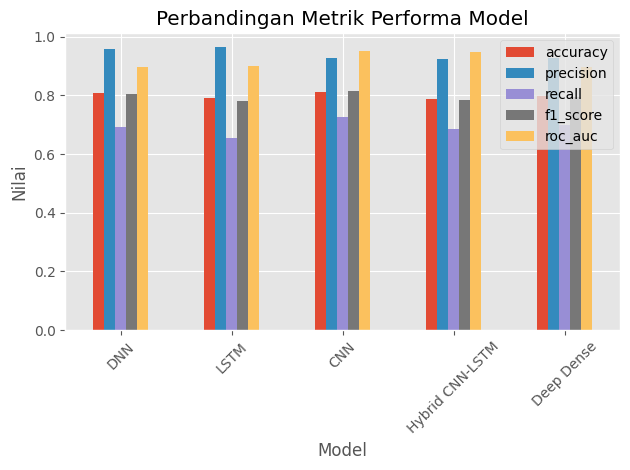

<Figure size 1400x600 with 0 Axes>

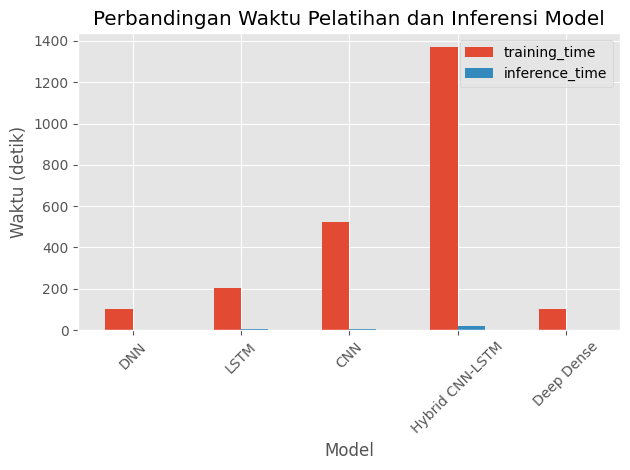


Model terbaik berdasarkan akurasi: CNN
Model terbaik telah disimpan sebagai 'best_ids_model.h5'


In [10]:
# Jalankan eksperimen
if __name__ == "__main__":
    all_results, comparison = run_experiment()

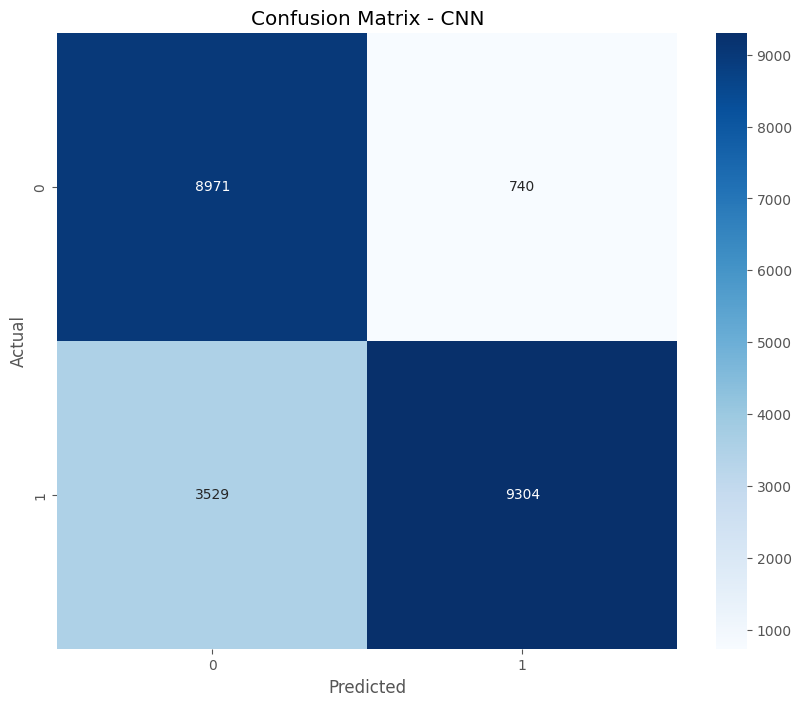

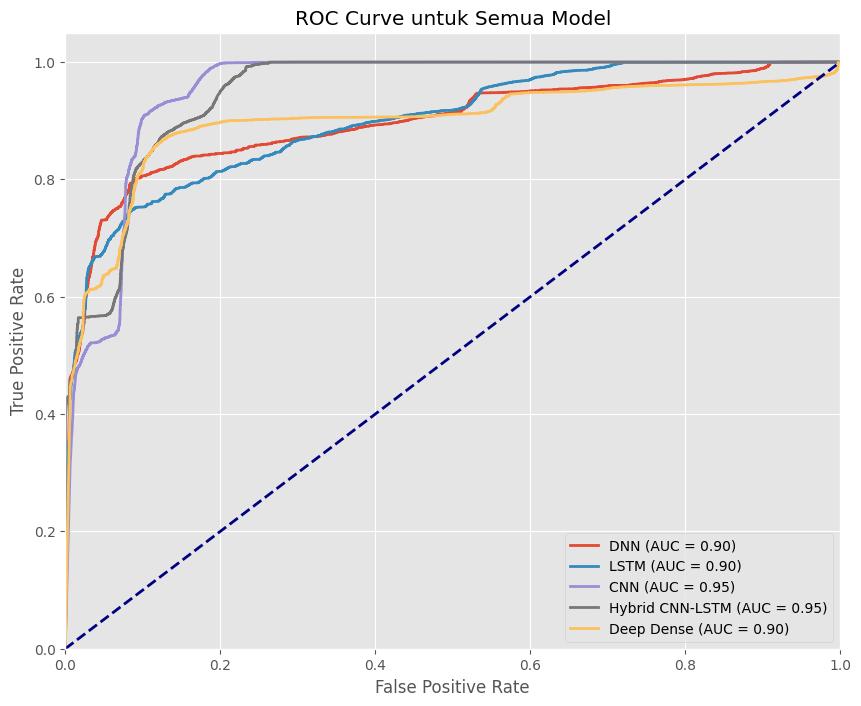

In [11]:
# Visualisasi confusion matrix model terbaik
best_model_name = comparison['accuracy'].idxmax()
cm = all_results[best_model_name]['confusion_matrix']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('best_model_confusion_matrix.png')
plt.show()

# Visualisasi ROC curve untuk semua model
plt.figure(figsize=(10, 8))
for model_name in all_results:
    fpr = all_results[model_name]['fpr']
    tpr = all_results[model_name]['tpr']
    roc_auc = all_results[model_name]['roc_auc']
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve untuk Semua Model')
plt.legend(loc="lower right")
plt.savefig('roc_curve_comparison.png')
plt.show()